Import the needed packages and ml modules 

In [16]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from  torch.utils.data import TensorDataset
# from torchsummary import summary
from torchinfo import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 
import contextily as cx
import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm
# Replace 'path_to_directory' with the actual path of the directory containing your Python experiment file
sys.path.append('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/deform')

In [17]:
try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'CT'
    train_size = '2500' 
    test_size = '6421' #6421(BS type sign deform) 0(BS and PS with no deform) 6317 (mis of all)
    mode = 'test'
    mask_size = '6317'
except:
    raise Exception("*** Must first set variable")


# load test events related parameters
event_list_path = f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt'
event_list = np.loadtxt(event_list_path, dtype='str')
    
n_eve = len(event_list)    

flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
nflood_grids = np.count_nonzero(flood_mask)

# Define the model region related size/architecture
if reg == 'SR':
   GaugeNo = list(range(53,58)) #rough pick for Siracusa
   x_dim = 1300  #lon
   y_dim = 948 #lat
   ts_dim = len(GaugeNo) #no of gauges time series
   reg_gaugeno = str(54)
   control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]
elif reg == 'CT':
   GaugeNo = list(range(35,44)) #for Catania
   x_dim = 912
   y_dim = 2224
   ts_dim = len(GaugeNo)
   reg_gaugeno = str(41)
   control_points =  [[37.5022,15.0960],
      [37.48876,15.08936],
      [37.47193,15.07816],
      [37.46273,15.08527],
      [37.46252,15.08587],
      [37.45312,15.07874],
      [37.42821,15.08506],
      [37.40958,15.08075],
      [37.38595,15.08539],
      [37.35084,15.08575],
      [37.33049,15.07029],]
   
pts = 480
z = 64
hdim = 64
channels_off = [64,128,256]
channels_on = [128,128,128]
channels_deform = [16,32,64,128]

import experiment as exp
exp.set_seed_settings(0)
# Load the model inputs for test events
t_array, red_d_array, red_dZ_array = exp.read_memmap(MLDir=MLDir,
                                                      reg=reg,
                                                      train_size=train_size,
                                                      test_size=test_size,
                                                      ts_dim=ts_dim,
                                                      pts_dim=pts,
                                                      n_eve = n_eve,
                                                      nflood_grids = nflood_grids,
                                                      what4 = mode,
                                                      normalize = False,
                                                      standardize = False)




cuda is: False
reading memmap for test data size: 6421


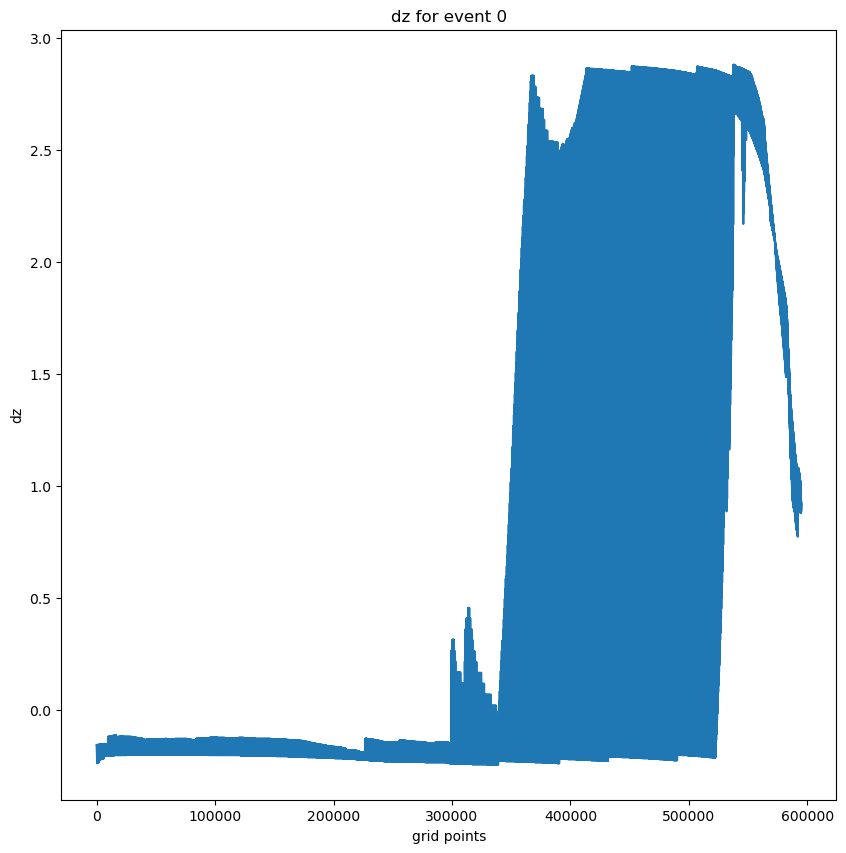

In [18]:
#plot dz for an event as 1 d array
plt.figure(figsize=(10,10))
plt.plot(red_dZ_array[5,:])
plt.title('dz for event 0')
plt.xlabel('grid points')
plt.ylabel('dz')
plt.show()



In [19]:
def Gfit(obs, pred): #a normalized least-squares per event in first dimensions
    print('obs shape', obs.shape,len(obs))
    Gtable = np.zeros(len(obs))
    for i in range(len(obs)):      
        obs_i = np.array(obs[i])
        pred_i = np.array(pred[i])
        Gvaluei = 1 - (2*np.sum(obs_i*pred_i)/(np.sum(obs_i**2)+np.sum(pred_i**2)))
        Gtable[i] = Gvaluei
    return Gtable

def Gfit_one(obs, pred): #a normalized least-squares
    obs = np.array(obs)
    pred = np.array(pred)
    Gvalue = 1 - (2*np.sum(obs*pred)/(np.sum(obs**2)+np.sum(pred**2)))
    return Gvalue

Onshore

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_onshore                      [300, 594725]             --
├─Sequential: 1-1                        [300, 128]                --
│    └─Linear: 2-1                       [300, 128]                76,124,928
│    └─LeakyReLU: 2-2                    [300, 128]                --
│    └─Linear: 2-3                       [300, 128]                16,512
│    └─LeakyReLU: 2-4                    [300, 128]                --
│    └─Linear: 2-5                       [300, 128]                16,512
│    └─LeakyReLU: 2-6                    [300, 128]                --
├─Sequential: 1-2                        [300, 594725]             --
│    └─Linear: 2-7                       [300, 128]                16,512
│    └─LeakyReLU: 2-8                    [300, 128]                --
│    └─Linear: 2-9                       [300, 128]                16,512
│    └─LeakyReLU: 2-10                   [300, 128]          

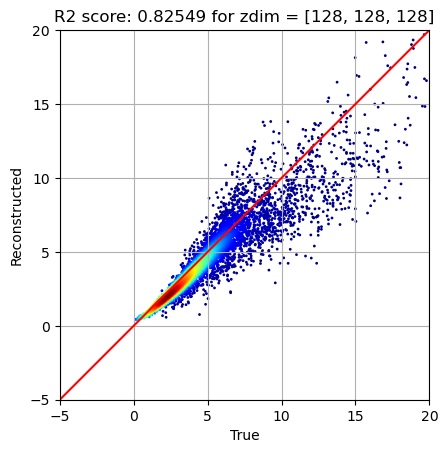

Text(0, 0.5, 'Score')

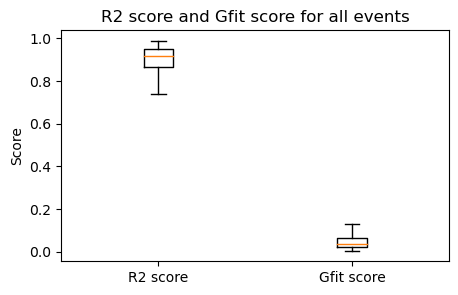

In [20]:
onshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_onshore_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))
# onshore_model = torch.load(f"/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/deform/sacred_logs/53/model_onshore_ch_[64, 64]_minepoch_6317.pt", map_location=torch.device('cpu'))
# Test model for final evaluation
#read model from file for testing
model = onshore_model
model.eval()
print(summary(model,(300,nflood_grids,)))
criterion = nn.MSELoss()
print(red_d_array.shape)
test_dataset = torch.tensor(red_d_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}")

recon_data = recon_data[:, :].cpu().detach().numpy()

# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_on = Gfit(test_dataset, recon_data)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# # Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# #count events with score above 0.7
print(np.sum(r2_scores_on > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_on < 0.1), 'events with Gfit score below 0.1')


# # Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

# # plt.figure(figsize=(5, 5))
# plt.scatter(test_max, recon_max, s=1)  
x = test_max
y = recon_max

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
index = z.argsort()
x, y, z = x[index], y[index], z[index]
plt.scatter(x, y, c=z, s=1, cmap='jet')  
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()


# #plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_on, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_on, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')


-0.06008603 5.2860317


tensor(0.) tensor(8.5623)
0.18618090995357217


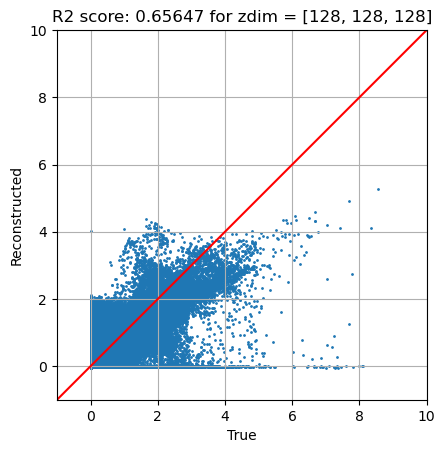

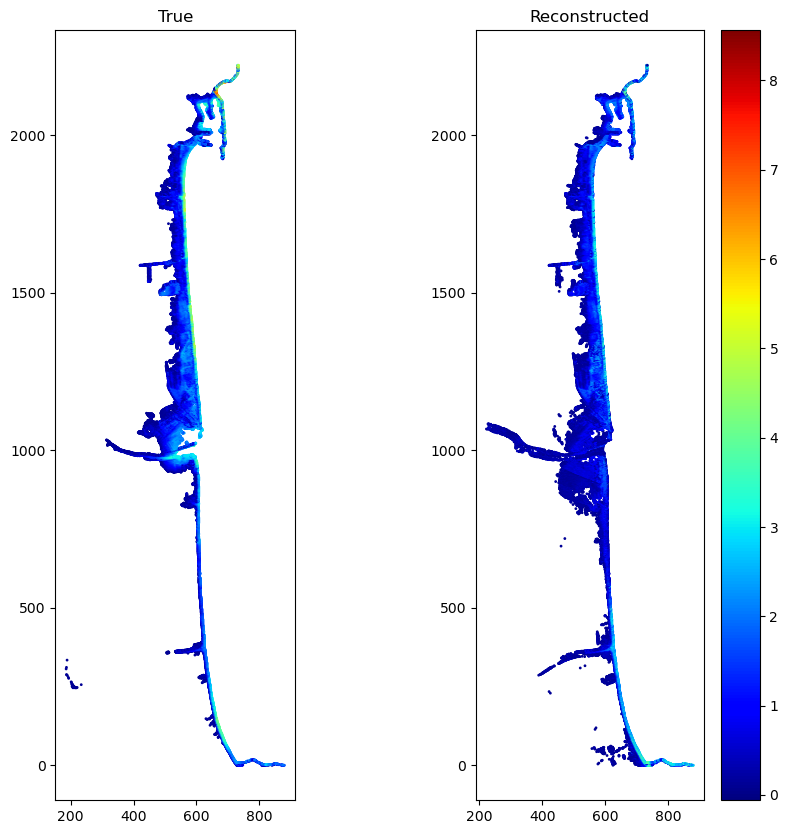

Run MLTSU-581 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-581/metadata


: 

In [21]:
eve_no = 6327
print(min(recon_data[eve_no,:]), max(recon_data[eve_no,:]))
print(min(test_dataset[eve_no,:]), max(test_dataset[eve_no,:]))

minval = min(min(recon_data[eve_no,:]), min(test_dataset[eve_no,:]))
maxval = max(max(recon_data[eve_no,:]), max(test_dataset[eve_no,:]))

print(Gfit_on[eve_no])

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()


idx= np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_CT_6317.npy')
#add recon and true column to to the idx array
idx = np.c_[idx,test_dataset[eve_no],recon_data[eve_no]]

#plot the true and recon values on the map as color side by side using lat lon 
#set idx[:,4] and idx[:,5] values below 0.1 to nan
idx[idx[:,4]<0.1,4] = np.nan
idx[idx[:,5]<0.1,5] = np.nan

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,4],s=1,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('True')
plt.clim(minval,maxval)
plt.subplot(1,2,2)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,5],s=1,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstructed')
plt.clim(minval,maxval)
plt.colorbar()
plt.show()


Deformation

In [5]:
# deform_model = torch.load(f"/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/deform/sacred_logs/70/model_deform_ch_[16, 32, 64]_minepoch_6317.pt", map_location=torch.device('cpu'))
deform_model = torch.load(f"{MLDir}/model/{reg}/out/model_deform_ch_{channels_deform}_minepoch_{train_size}.pt", map_location=torch.device('cpu')) # Test model for final evaluation
#read model from file for testing
model = deform_model
model.eval()
print(summary(model,(300,nflood_grids,)))
criterion = nn.MSELoss()
print(red_dZ_array.shape)
test_dataset = torch.tensor(red_dZ_array[:4000], dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")
del test_dataset

recon_data = recon_data[:, :].cpu().detach().numpy()


torch.Size([300, 1, 594747])
Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_deformation                  [300, 594725]             --
├─Sequential: 1-1                        [300, 128, 41]            --
│    └─Conv1d: 2-1                       [300, 16, 148681]         128
│    └─LeakyReLU: 2-2                    [300, 16, 148681]         --
│    └─MaxPool1d: 2-3                    [300, 16, 14868]          --
│    └─Conv1d: 2-4                       [300, 32, 7433]           2,592
│    └─LeakyReLU: 2-5                    [300, 32, 7433]           --
│    └─MaxPool1d: 2-6                    [300, 32, 1486]           --
│    └─Conv1d: 2-7                       [300, 64, 743]            6,208
│    └─LeakyReLU: 2-8                    [300, 64, 743]            --
│    └─MaxPool1d: 2-9                    [300, 64, 247]            --
│    └─Conv1d: 2-10                      [300, 128, 124]           24,704
│    └─LeakyReLU: 2-11                   [300

obs shape (4000, 594725) 4000


2394 events with R2 score above 0.7
3984 events with Gfit score below 0.1


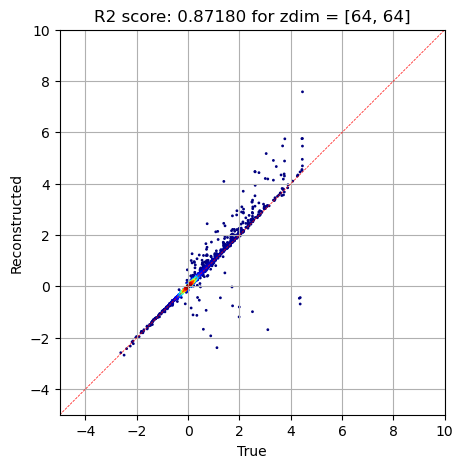

Text(0, 0.5, 'Score')

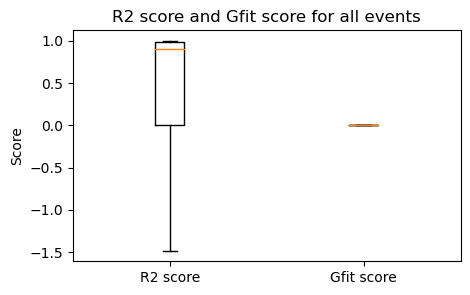

In [6]:
# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_on = Gfit(red_dZ_array[:4000], recon_data)
flat_table1 = np.transpose(red_dZ_array[:4000])
flat_table2 = np.transpose(recon_data)


# Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# #count events with score above 0.7
print(np.sum(r2_scores_on > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_on < 0.1), 'events with Gfit score below 0.1')


# Plot results max height for all events
test_max = np.max(red_dZ_array[:4000],axis=(1))
recon_max = np.max(recon_data,axis=(1))

x = test_max
y = recon_max

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
index = z.argsort()
x, y, z = x[index], y[index], z[index]
plt.figure(figsize=(5, 5))
plt.scatter(x, y, c=z, s=1, cmap='jet') 


# plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--', linewidth=0.5)
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_on, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_on, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')

0.033562526 0.04568349
0.035858701914548874 0.04501411318778992
9.663730759068567e-05


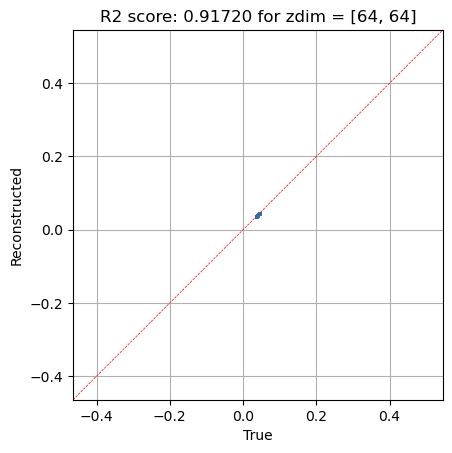

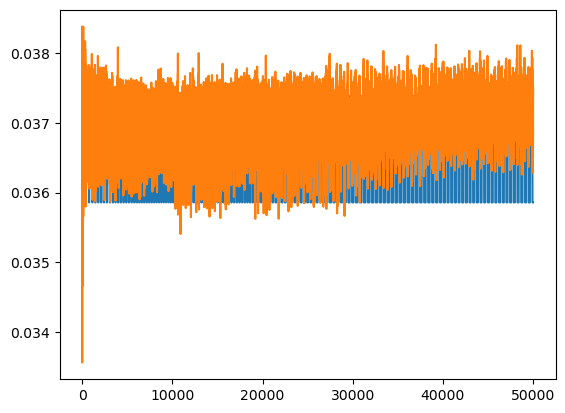

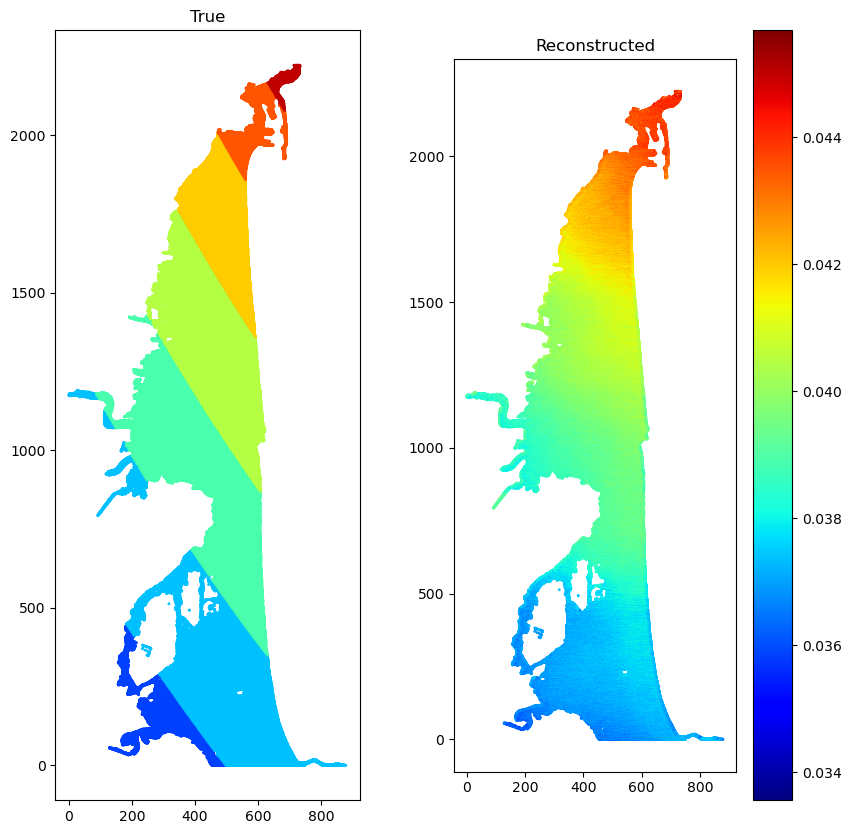

In [7]:
eve_no = 1856
print(min(recon_data[eve_no,:]), max(recon_data[eve_no,:]))
print(min(red_dZ_array[eve_no,:]), max(red_dZ_array[eve_no,:]))

minval = min(min(recon_data[eve_no,:]), min(red_dZ_array[eve_no,:]))
maxval = max(max(recon_data[eve_no,:]), max(red_dZ_array[eve_no,:]))

print(Gfit_on[eve_no])

plt.scatter(red_dZ_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_dZ_array[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

mi,ma = min(red_dZ_array[eve_no,:])-0.5, max(red_dZ_array[eve_no,:])+0.5
plt.xlim(mi,ma)
plt.ylim(mi,ma)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# print(min(flat_table2[:,eve_no]))
# plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
# plt.title(f"R2 score: {r2_score(flat_table1[:,eve_no], flat_table2[:,eve_no]):.5f} for zdim = {channels_on}")
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim(-1, 10)
# plt.ylim(-1, 10)
# plt.grid()
# plt.xlabel('True')
# plt.ylabel('Reconstructed')
# plt.show()

plt.plot(red_dZ_array[eve_no,:50000], label='True')
plt.plot(recon_data[eve_no,:50000], label='Reconstructed')

idx= np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_CT_6317.npy')
#add recon and true column to to the idx array
idx = np.c_[idx,red_dZ_array[eve_no],recon_data[eve_no]]

#plot the true and recon values on the map as color side by side using lat lon 

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,4],s=1,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('True')
plt.clim(minval,maxval)
plt.subplot(1,2,2)
plt.scatter(idx[:,1],idx[:,0],c=idx[:,5],s=1,cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstructed')
plt.clim(minval,maxval)
plt.colorbar()
plt.show()



Final Coupled Model

In [5]:
couple_model = torch.load(f'{MLDir}/model/{reg}/out/model_couple_off{channels_off}_on{channels_on}_minepoch_{train_size}.pt', map_location=torch.device('cpu'))


model = couple_model
model.eval()
print(summary(model,[(300,ts_dim,pts),(300,nflood_grids,)]))
criterion = nn.MSELoss()

print(t_array.shape)
test_dataset_in = torch.tensor(t_array[:5000], dtype=torch.float32).to('cpu')
print(test_dataset_in.shape)
print(red_d_array.shape)
test_dataset_out = torch.tensor(red_d_array[:5000], dtype=torch.float32).to('cpu')
print(test_dataset_out.shape)
print(red_dZ_array.shape)
test_dataset_deform = torch.tensor(red_dZ_array[:5000], dtype=torch.float32).to('cpu')
print(test_dataset_deform.shape)

#evaluate model in batch and combine reconstructions to get full dataset

with torch.no_grad():
    recon_data = model(test_dataset_in, test_dataset_deform)
tloss = criterion(recon_data, test_dataset_out)

print(f"Test loss: {tloss :.5f}")
recon_data1 = recon_data[:, :].cpu().detach().numpy()


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_coupled                      [300, 594725]             --
├─Sequential: 1-1                        [300, 256, 60]            --
│    └─Conv1d: 2-1                       [300, 64, 480]            (1,792)
│    └─LeakyReLU: 2-2                    [300, 64, 480]            --
│    └─MaxPool1d: 2-3                    [300, 64, 240]            --
│    └─Conv1d: 2-4                       [300, 128, 240]           (24,704)
│    └─LeakyReLU: 2-5                    [300, 128, 240]           --
│    └─MaxPool1d: 2-6                    [300, 128, 120]           --
│    └─Conv1d: 2-7                       [300, 256, 120]           (98,560)
│    └─LeakyReLU: 2-8                    [300, 256, 120]           --
│    └─MaxPool1d: 2-9                    [300, 256, 60]            --
│    └─Dropout: 2-10                     [300, 256, 60]            --
├─Sequential: 1-2                        [300, 64]                 -

torch.Size([5000, 594725])
Test loss: 0.01937


In [6]:
print(t_array.shape)
test_dataset_in = torch.tensor(t_array[5000:], dtype=torch.float32).to('cpu')
print(test_dataset_in.shape)
print(red_d_array.shape)
test_dataset_out = torch.tensor(red_d_array[5000:], dtype=torch.float32).to('cpu')
print(test_dataset_out.shape)
print(red_dZ_array.shape)
test_dataset_deform = torch.tensor(red_dZ_array[5000:], dtype=torch.float32).to('cpu')
print(test_dataset_deform.shape)

#evaluate model in batch and combine reconstructions to get full dataset

with torch.no_grad():
    recon_data = model(test_dataset_in, test_dataset_deform)
tloss = criterion(recon_data, test_dataset_out)

print(f"Test loss: {tloss :.5f}")

recon_data2 = recon_data[:, :].cpu().detach().numpy()

(6315, 9, 480)
torch.Size([1315, 9, 480])
(6315, 594725)
torch.Size([1315, 594725])
(6315, 594725)
torch.Size([1315, 594725])
Test loss: 0.02850


In [7]:
#append reconstructions 1 and 2
recon_data = np.append(recon_data1,recon_data2,axis=0)
del recon_data1,recon_data2,test_dataset_in,test_dataset_deform,test_dataset_out

Analysis and plotting

obs shape (6315, 594725) 6315
5836 events with R2 score above 0.7
5317 events with Gfit score below 0.1


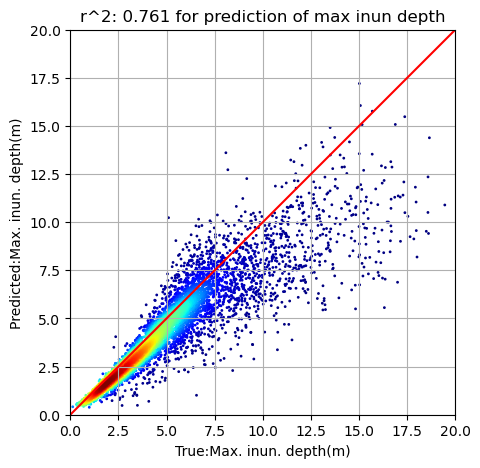

Text(0, 0.5, 'Score')

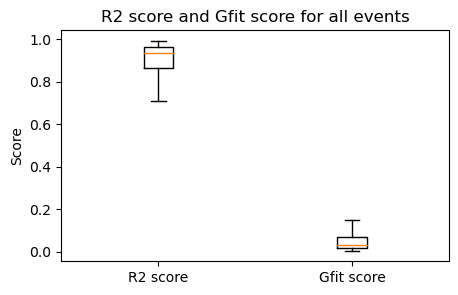

In [8]:
# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_out = Gfit(red_d_array, recon_data)
flat_table1 = np.transpose(red_d_array)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_out = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
print(np.sum(r2_scores_out > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_out < 0.1), 'events with Gfit score below 0.1')

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

x = test_max
y = recon_max

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
index = z.argsort()
x, y, z = x[index], y[index], z[index]
plt.figure(figsize=(5, 5))
plt.scatter(x, y, c=z, s=1, cmap='jet') 
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(test_max, recon_max):.3f} for prediction of max inun depth")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid()
plt.xlabel('True:Max. inun. depth(m)')
plt.ylabel('Predicted:Max. inun. depth(m)')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_out, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_out, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')

In [9]:
#save reconstructions
np.save(f'{MLDir}/model/{reg}/out/recon_data_{reg}_{test_size}.npy',recon_data)
#save r2 and gfit scores
np.save(f'{MLDir}/model/{reg}/out/r2_scores_{reg}_{test_size}.npy',r2_scores_out)
np.save(f'{MLDir}/model/{reg}/out/Gfit_{reg}_{test_size}.npy',Gfit_out)

In [10]:
#read reconstructions and scores
recon_data = np.load(f'{MLDir}/model/{reg}/out/recon_data_{reg}_{test_size}.npy')
r2_scores_out = np.load(f'{MLDir}/model/{reg}/out/r2_scores_{reg}_{test_size}.npy')
Gfit_out = np.load(f'{MLDir}/model/{reg}/out/Gfit_{reg}_{test_size}.npy')

-0.015607568 10.157372
0.0 6.667891979217529
0.028612747439122788


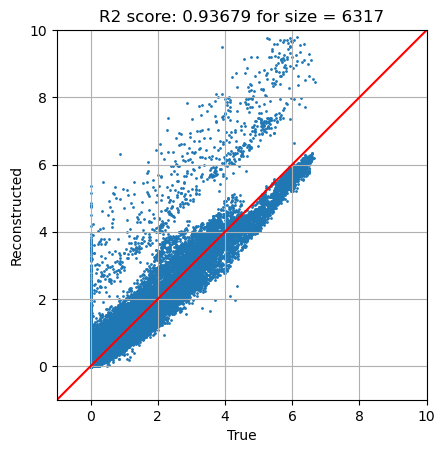

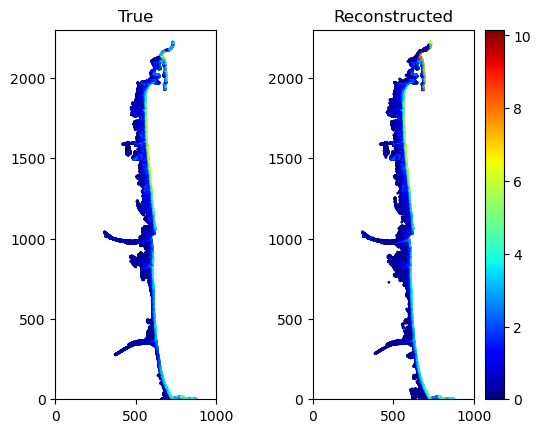

In [11]:
eve_no = 2077
print(min(recon_data[eve_no,:]), max(recon_data[eve_no,:]))
print(min(red_d_array[eve_no,:]), max(red_d_array[eve_no,:]))

minval = min(min(recon_data[eve_no,:]), min(red_d_array[eve_no,:]))
maxval = max(max(recon_data[eve_no,:]), max(red_d_array[eve_no,:]))

print(Gfit_out[eve_no])

plt.scatter(red_d_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_d_array[eve_no,:], recon_data[eve_no,:]):.5f} for size = {train_size}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

idx= np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/lat_lon_idx_CT_6317.npy')
#add recon and true column to to the idx array
idx = np.c_[idx,red_d_array[eve_no],recon_data[eve_no]]

#plot the true and recon values on the map as color side by side using lat lon 

# Plot True
plt.subplot(1, 2, 1)
data2plot = idx[:, 4]
data2plot[np.where(data2plot < 0.1)] = np.nan
true_scatter = plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=1, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('True')
plt.clim(0, maxval)
plt.xlim(0, 1000)
plt.ylim(0, 2300)

# Plot Reconstructed with transparency for values less than 0.1
plt.subplot(1, 2, 2)
data2plot = idx[:, 5]
data2plot[np.where(data2plot < 0.1)] = np.nan
reconstructed_scatter = plt.scatter(idx[:, 1], idx[:, 0], c=data2plot, s=1, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Reconstructed')
plt.clim(0, maxval)
plt.xlim(0, 1000)
plt.ylim(0, 2300)


plt.colorbar()
plt.show()


In [12]:
def calc_scores(true,pred,locindices,threshold=0.2):
    truecopy = true.copy()
    #only test where there is significant flooding
    truecopy[truecopy<threshold] = 0
    pred[pred<threshold] = 0
    mse_val = mean_squared_error(truecopy,pred)
    r2_val = r2_score(truecopy,pred)
    Gfit_val = Gfit_one(truecopy,pred)
    pt_er = truecopy[locindices] - pred[locindices]

    #calculate Aidan's no K and k small
    # ratio = true[true>=threshold]/pred[true>=threshold]    
    # logK = np.exp((np.log(ratio)).mean()) # Aidan's no K
    # logksmall = (np.mean((np.log(ratio))**2) - (logK**2))**0.5
    # Kcap = np.exp(logK)
    # Ksmall = np.exp(logksmall)

    return mse_val,r2_val,truecopy[locindices],pred[locindices],pt_er,Gfit_val#,Kcap,Ksmall


In [13]:
if reg == 'CT':
  control_points =  [[37.5022,15.0960],
            [37.48876,15.08936],
            [37.47193,15.07816],
            [37.46851,15.08337], #airport 37.46851594, 15.08337672
            [37.46252,15.08587],
            [37.45312,15.07874],
            [37.42821,15.08506],
            [37.40958,15.08075],
            [37.38595,15.08539],
            [37.35084,15.08575],
            [37.33049,15.07029],
            [37.40675,15.05037] 
            ]
elif reg == 'SR':
  control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]


def get_idx_from_latlon(locations,reg=reg,MLDir=MLDir,SimDir=SimDir,mask_size=mask_size):  
    #get first event to get lat lon
    firstevent = np.loadtxt(f'{MLDir}/data/events/sample_events53550.txt',dtype='str')[0]
    D_grids = xr.open_dataset(f'{SimDir}/{firstevent}/{reg}_flowdepth.nc')
    zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    non_zero_list = np.argwhere(~zero_mask).tolist()

    #iterate over list locations
    indices = []
    for loc in locations: 
        #get index of lat lon
        lat_idx = np.argmin(np.abs(D_grids.lat.values - loc[0]))
        lon_idx = np.argmin(np.abs(D_grids.lon.values - loc[1]))

        #get idx in non zero mask list from lat_idx and lon_idx
        idx = non_zero_list.index([lat_idx,lon_idx])
        indices.append(idx)

    # return lat_idx, lon_idx, idx
    print(indices)


    #calculate lat lon for all non zero list



    return indices

locindices = get_idx_from_latlon(control_points)
        #points to evaluate
# (2130, 653, 416589)
# (1980, 595, 406966)
# (1794, 496, 382850)
# (1691, 559, 366654)
# (1689, 564, 366384)
# (1585, 501, 348891)
# (1308, 557, 300485)
# (1101, 519, 261213)
# (839, 560, 196458)
# (450, 563, 127165)
# (224, 427, 61790)
# (1070, 252, 252416)



[588818, 576495, 544931, 536893, 521035, 495118, 412014, 330881, 233973, 158721, 84142, 315860]


In [16]:
#check performance per event
eve_perf = []
true_list = []
pred_list = []
er_list = []
threshold = 0.2

#mse_val,r2_val,true[locindices],pred[locindices],pt_er,Gfit_val #,KCap,Ksmall
for eve_no,eve in enumerate(event_list):
    if eve_no % 1000==0:
        print(eve_no)
    scores = calc_scores(red_d_array[eve_no,:], recon_data[eve_no,:],locindices,threshold)
    eve_perf.append([scores[0],scores[1],scores[5],#scores[6],scores[7], #mse,r2,Gfit,KCap,Ksmall
                     np.count_nonzero(red_d_array[eve_no,:]), #true count
                     np.count_nonzero(recon_data[eve_no,:])]), #pred count
    
    true_list.append(scores[2])
    pred_list.append(scores[3])
    er_list.append(scores[4])

#count of events less than 
eve_perf = np.array(eve_perf)
true_list = np.array(true_list)
pred_list = np.array(pred_list)
er_list = np.array(er_list)

#combine columns of true,pred,er into 12 column array
true_pred_er = np.column_stack((true_list,pred_list,er_list))

#append column with value from multiplie of column 0 and 4
eve_perf = np.column_stack((eve_perf,eve_perf[:,0]*eve_perf[:,4]))

#save to file
np.savetxt(f"{MLDir}/model/{reg}/out/er_coupled_finetuned_epoch_min_{test_size}.csv",true_pred_er,fmt='%.5f',delimiter=',')
np.savetxt(f"{MLDir}/model/{reg}/out/eve_perf_coupled_finetuned_epoch_min_{test_size}.csv",eve_perf,fmt='%.5f',delimiter=',')


0


1000
2000
3000
4000
5000
6000


In [18]:
#load from file
true_pred_er = np.loadtxt(f"{MLDir}/model/{reg}/out/er_coupled_finetuned_epoch_min_{test_size}.csv",delimiter=',')
eve_perf = np.loadtxt(f"{MLDir}/model/{reg}/out/eve_perf_coupled_finetuned_epoch_min_{test_size}.csv",delimiter=',')

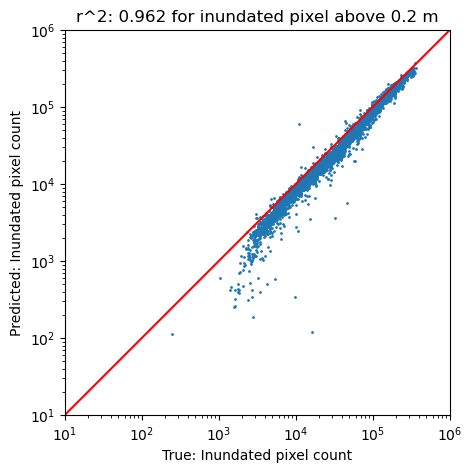

In [19]:
#plot scatter of flood count
plt.figure(figsize=(5, 5))
plt.scatter(eve_perf[:,3], eve_perf[:,4], s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(eve_perf[:,3], eve_perf[:,4]):.3f} for inundated pixel above 0.2 m")
plt.gca().set_aspect('equal', adjustable='box')
#use log scale
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 1000000)
plt.ylim(10, 1000000)
# plt.grid()
plt.xlabel('True: Inundated pixel count')
plt.ylabel('Predicted: Inundated pixel count')
plt.show()

Control Location:1,No of flood events:1657/6315
Control Location:2,No of flood events:2443/6315
Control Location:3,No of flood events:842/6315
Control Location:4,No of flood events:1042/6315
Control Location:5,No of flood events:5014/6315
Control Location:6,No of flood events:702/6315
Control Location:7,No of flood events:2102/6315
Control Location:8,No of flood events:305/6315
Control Location:9,No of flood events:2746/6315
Control Location:10,No of flood events:819/6315
Control Location:11,No of flood events:127/6315
Control Location:12,No of flood events:56/6315


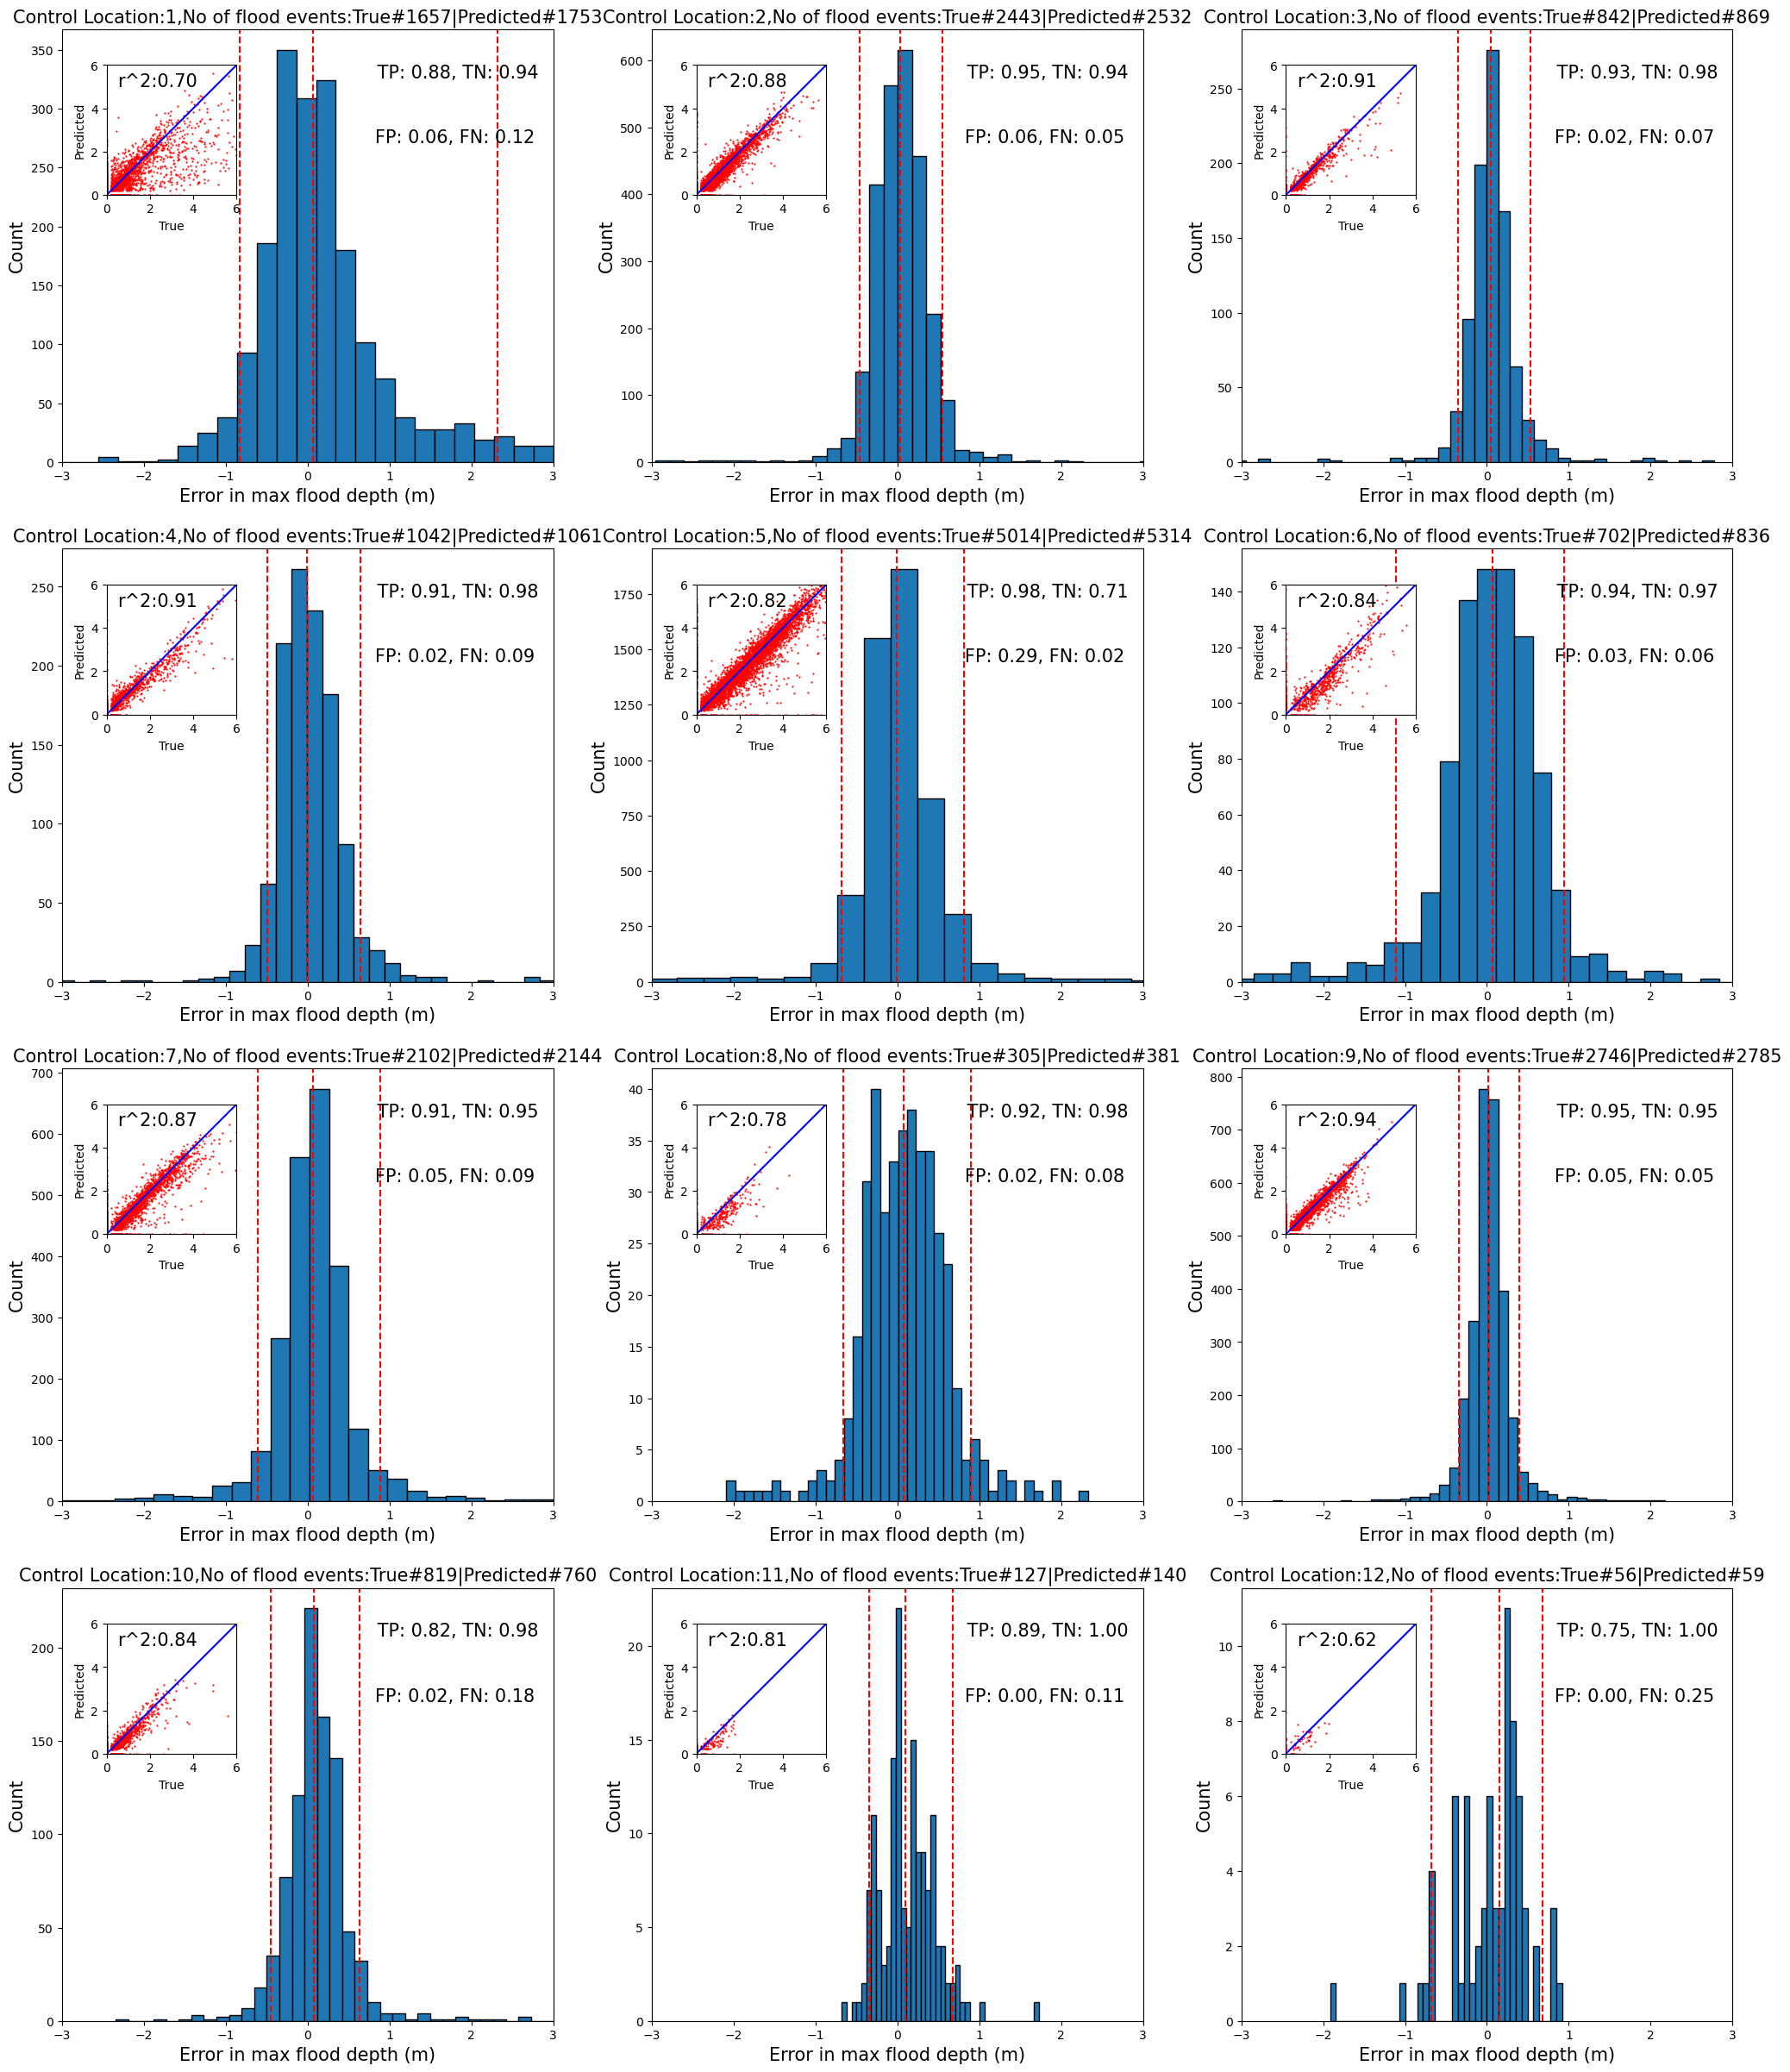

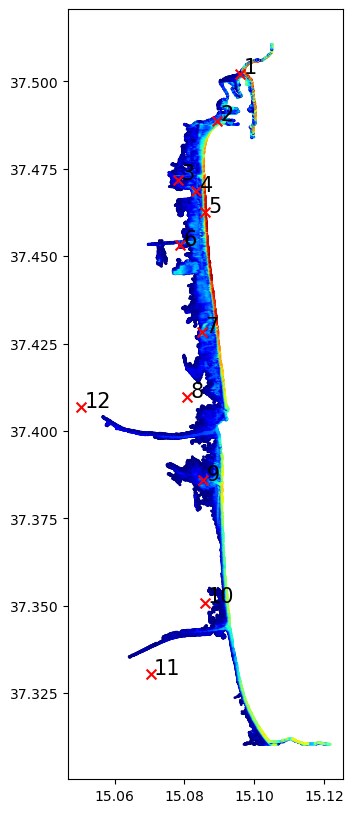

In [20]:

#plot the errors for the control locations as subplot from all events as histogram
plt.figure(figsize=(25, 30))
for i in range(len(locindices)):
    ax = plt.subplot(4, 3, i + 1)   
    # Plot the histogram of errors for the control locations
    plt.hist(er_list[er_list[:,i]!=0,i],bins=40,edgecolor='black',)
    quantiles = np.percentile(er_list[er_list[:,i]!=0,i], [5, 50, 95])
    # Plot quantile lines
    for q in quantiles:
        ax.axvline(q, color='red', linestyle='--', label=f'Q{int(q)}')
    ax.set_xlim(-3, 3)

    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold say 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    neve_recon = np.count_nonzero(true_pred_er[:,i+len(locindices)]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(len(true_pred_er[:,i])-neve)
    plt.title(f"Control Location:{i+1},No of flood events:True#{neve}|Predicted#{neve_recon}",fontsize=15)
    plt.text(0.8, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.text(0.8, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.xlabel('Error in max flood depth (m)',fontsize=15)
    plt.ylabel('Count',fontsize=15)

    # Create a new inset axis for the scatter plot
    axins = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=3)
    
    # Scatter plot of values (replace with your data)
    axins.plot([0, 1], [0, 1], transform=axins.transAxes, color='blue',)
    axins.scatter(true_pred_er[:,i], true_pred_er[:,i+len(locindices)], marker='o', color='red', label='Max Inun Depth',s=0.33)  # Customize marker and color as needed
    axins.text(0.5,5,f'r^2:{r2_score(true_pred_er[:,i], true_pred_er[:,i+len(locindices)]):.2f}',fontsize=15)
    axins.set_xlim(0, 6)  # Adjust x-axis limits for the scatter plot
    axins.set_ylim(0, 6)  # Adjust y-axis limits for the scatter plot
    axins.set_xlabel('True')
    axins.set_ylabel('Predicted')
    axins.set_aspect('equal', adjustable='box')
    
    
# Using enumerate to add index to the list of coordinates
coordinates_list = pd.DataFrame(control_points,columns=['lat','lon'])
coordinates_list['id'] = coordinates_list.index+1
plt.figure(figsize=(5,10))
plt.scatter(idx[:, 3], idx[:, 2], c=idx[:, 4], s=1, cmap='jet')
plt.scatter(coordinates_list['lon'],coordinates_list['lat'], marker='x', s=50, c='red')
for i, txt in enumerate(coordinates_list['id']):
    plt.annotate(txt, (coordinates_list['lon'][i]+0.001,coordinates_list['lat'][i]),fontsize=15)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


    # plt.grid()
# plt.suptitle(f"Error distribution for the control locations for {len(eve_perf)} test events")

/tmp/ipykernel_1555004/2772291736.py:5: RuntimeWarning: divide by zero encountered in divide
  reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)
/tmp/ipykernel_1555004/2772291736.py:5: RuntimeWarning: invalid value encountered in divide
  reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)


Control Location:1,No of flood events:1657/6315
Control Location:2,No of flood events:2443/6315
Control Location:3,No of flood events:842/6315
Control Location:4,No of flood events:1042/6315
Control Location:5,No of flood events:5014/6315
Control Location:6,No of flood events:702/6315
Control Location:7,No of flood events:2102/6315
Control Location:8,No of flood events:305/6315
Control Location:9,No of flood events:2746/6315
Control Location:10,No of flood events:819/6315
Control Location:11,No of flood events:127/6315
Control Location:12,No of flood events:56/6315


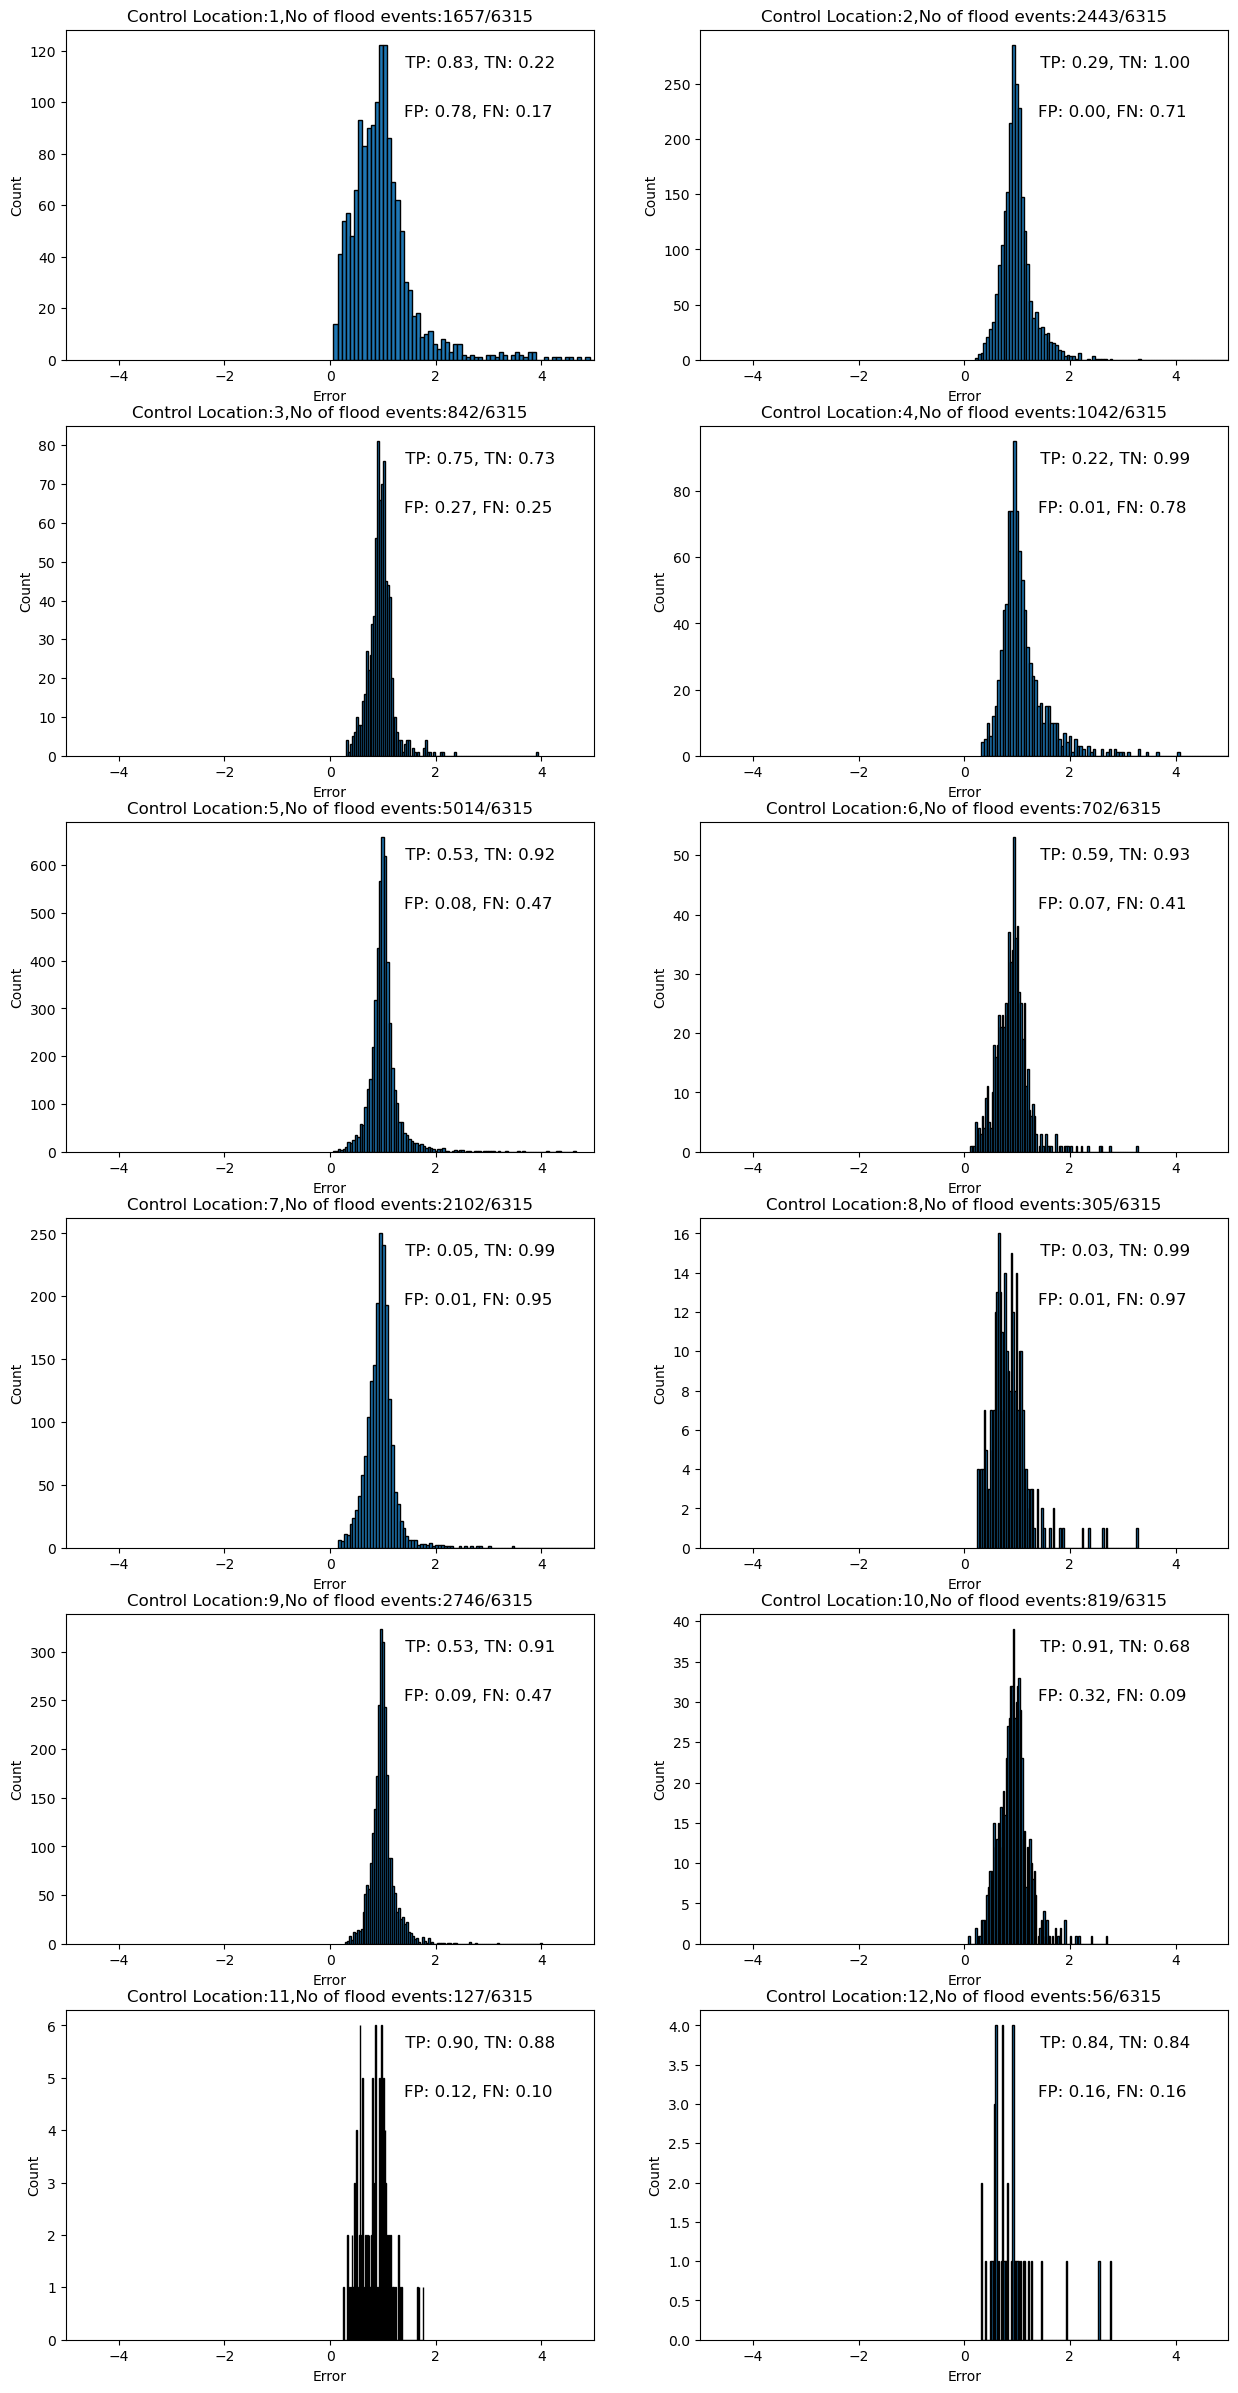

In [21]:
#set true value less than threshold to zero
true_list[true_list<threshold] = 0

#calculate rel error for each row/column variable where er is not zero
reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)

#plot the errors for the control locations as subplot from all events as histogram
plt.figure(figsize=(15, 30))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.hist(reler_list[reler_list[:,i]!=0,i],bins=100,edgecolor='black')
    #set x axis to be the same for all subplots
    plt.xlim(-5,5)
    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold of 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+4]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+4]>threshold))/(len(true_pred_er[:,i])-neve)
    plt.title(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    plt.text(0.78, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.text(0.78, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.xlabel('Error')
    plt.ylabel('Count')
    # plt.grid()
# plt.suptitle(f"Error distribution for 4 control locations for {len(eve_perf)} test events")

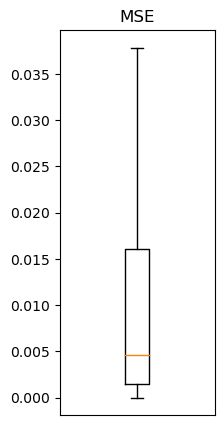

([], [])

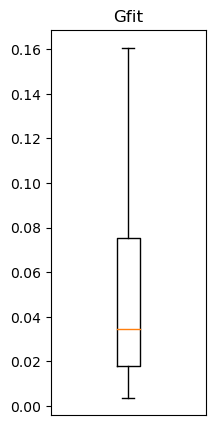

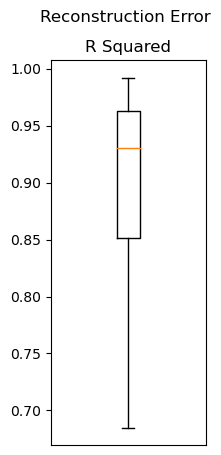

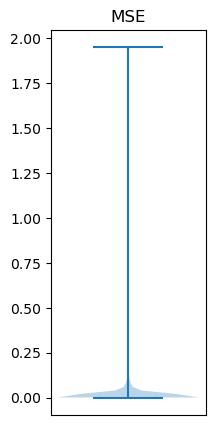

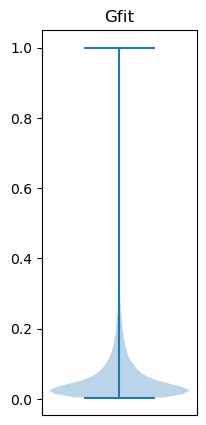

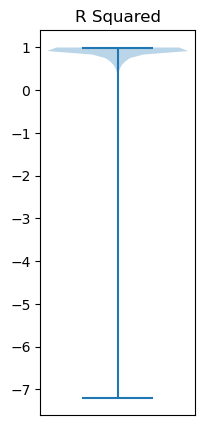

In [22]:
#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,0],showfliers=False)
plt.title('MSE')
plt.xticks([])
plt.show()

#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,2],showfliers=False)
plt.title('Gfit')
plt.xticks([])


plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,1],showfliers=False)
plt.title('R Squared')
plt.xticks([])

plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events


# #make violin plot of the errors
# plt.figure(figsize=(15, 10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.violinplot(er_list[er_list[:,i]!=0,i],showmeans=True)
#     plt.xlim(-1,1)
#     plt.title(f"Control Location:{i+1}")
#     plt.xlabel('Error')
#     plt.ylabel('Count')
#     # plt.grid()


#make violin plot of the errors MSE and R2
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,0],showmeans=False)
plt.title('MSE')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,2],showmeans=False)
plt.title('Gfit')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,1],showmeans=False)
plt.title('R Squared')
plt.xticks([])
# plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events



In [23]:
for param in model.offshore_encoder.parameters():
    print(param.shape, param.requires_grad)

for param in model.offshore_fc1.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True


In [24]:
for param in model.onshore_decoder.parameters():
    print(param.shape, param.requires_grad)


torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([594725, 64]) False
torch.Size([594725]) False


In [25]:
for param in model.deform_encoder.parameters():
    print(param.shape, param.requires_grad)

for param in model.deform_fc1.parameters():
    print(param.shape, param.requires_grad)

torch.Size([16, 1, 7]) False
torch.Size([16]) False
torch.Size([32, 16, 5]) False
torch.Size([32]) False
torch.Size([64, 32, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([64, 5248]) True
torch.Size([64]) True


In [26]:
for param in model.connect.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 128]) True
torch.Size([64]) True


In [27]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([16, 1, 7]) False
torch.Size([16]) False
torch.Size([32, 16, 5]) False
torch.Size([32]) False
torch.Size([64, 32, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([64, 5248]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([594725, 64]) False
torch.Size([594725]) False
torch.Size([64, 128]) True
torch.Size([64]) True


<Figure size 1000x600 with 0 Axes>

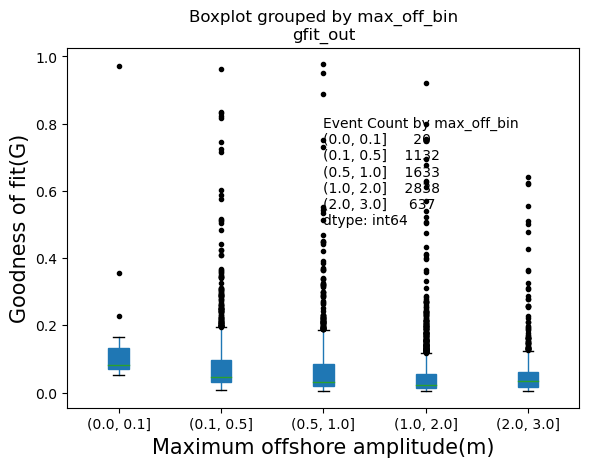

In [28]:
#append r2_scores_out to true_pred_er columns 
table = pd.DataFrame(true_pred_er)
table['r2_scores_out'] = r2_scores_out
table['id'] = event_list
table['gfit_out'] = Gfit_out
table['mse'] = eve_perf[:,0]
table['true'] = eve_perf[:,3]
table['pred'] = eve_perf[:,4]

#read sampling file and append to table based on event_id
sampling_file = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_CT_41.csv')
table = table.merge(sampling_file, on='id', how='left')
#save to output file
table.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/BStrue_pred_er_r2scores_{test_size}.csv', index=False)

# Set the bin edges for 'max_off' values
bin_edges = [0, 0.1, 0.5, 1, 2, 3]  # Define your custom bin edges here

# Create a box plot of 'gfit_out' binned by 'max_off' using custom bin edges
plt.figure(figsize=(10, 6))
table['max_off_bin'] = pd.cut(table['max_off'], bin_edges)
table.boxplot(column='gfit_out', by='max_off_bin', vert=True, showfliers=True,widths=0.2,sym='k.',patch_artist=True)
bin_counts = table.groupby('max_off_bin').size()
# Set labels and titles
plt.ylabel('Goodness of fit(G)',fontsize=15)
plt.xlabel('Maximum offshore amplitude(m)',fontsize=15)
plt.text(3, 0.5, f'Event Count by {bin_counts}')
#turn off grid
plt.grid(False)
# Show the plot
plt.show()


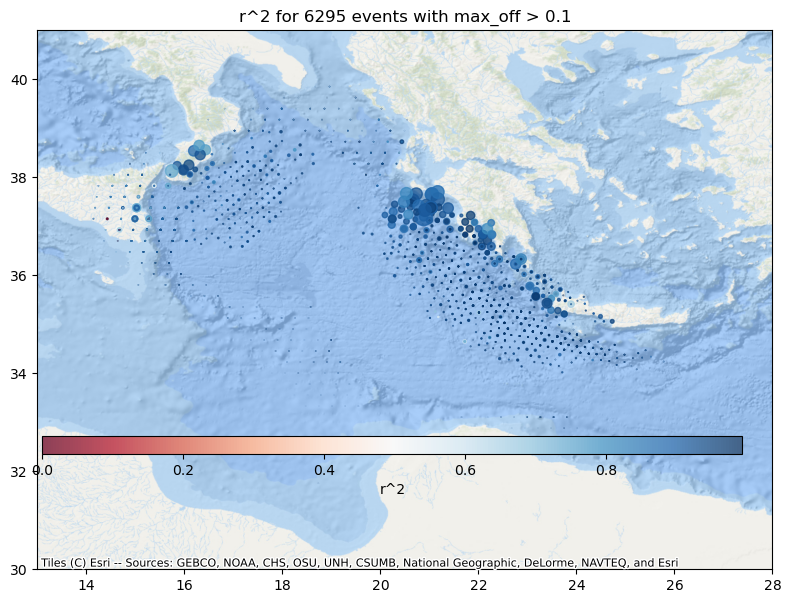

In [29]:
#plot events with lat lon and r2score as color
#load file
sample_test = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/BStrue_pred_er_r2scores_{test_size}.csv')

sample_test = sample_test[sample_test['max_off'] > 0.1]

#set r2score to -1 if it is negative
sample_test.loc[sample_test['r2_scores_out'] < 0, 'r2_scores_out'] = 0
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('r^2 for ' + str(len(sample_test)) + ' events with max_off > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['r2_scores_out'],
                      cmap='RdBu', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(13, 28)
plt.ylim(30, 41)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='r^2')

# Show the plot
plt.show()


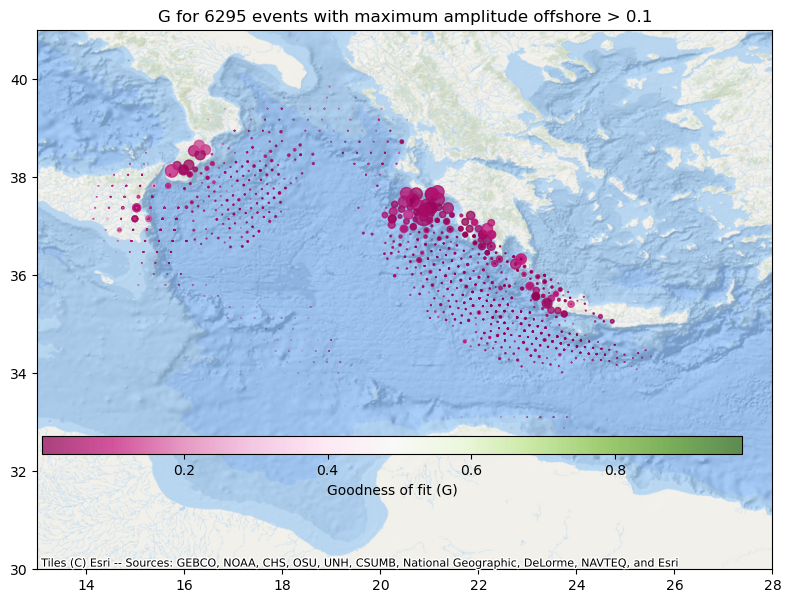

In [30]:
import matplotlib.pyplot as plt
import contextily as cx

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('G for ' + str(len(sample_test)) + ' events with maximum amplitude offshore > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['gfit_out'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(13, 28)
plt.ylim(30, 41)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='Goodness of fit (G)')

# Show the plot
plt.show()


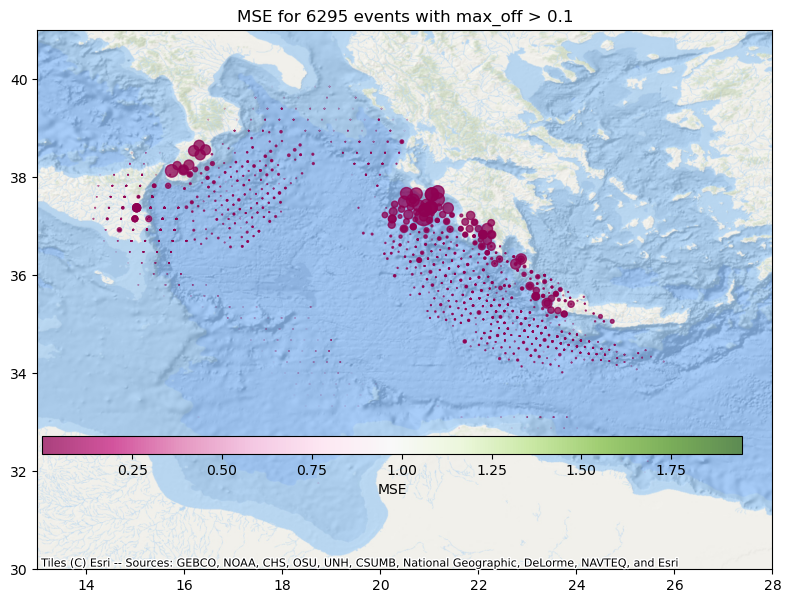

In [31]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('MSE for ' + str(len(sample_test)) + ' events with max_off > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['mse'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(13, 28)
plt.ylim(30, 41)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='MSE')

# Show the plot
plt.show()